# Parameterisation

In this notebook, we explain different concepts of parameterisation in `pybamm`. The concepts explained are listed below - 

1. Adding your own parameter sets (using a dictionary)
2. Finding the parameters in a model
3. Plotting parameter functions

### Some useful related examples are linked below:

- The API documentation of [Parameters](https://pybamm.readthedocs.io/en/latest/source/parameters/index.html) can be found at [pybamm.readthedocs.io](https://pybamm.readthedocs.io/)
- [Setting parameter values](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Getting%20Started/Tutorial%204%20-%20Setting%20parameter%20values.ipynb) can be found at `pybamm/examples/notebooks/Getting Started/Tutorial 4 - Setting parameter values.ipynb`
- [parameter-management.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/parameter-management.ipynb) can be found at `pybamm/examples/notebooks/parameter-management.ipynb`
- [parameter-values.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/parameter-values.ipynb) can be found at `pybamm/examples/notebooks/parameter-values.ipynb`


## Adding your own parameter sets (using a dictionary)

We will be using the model defined and explained in great detail in [3-negative-particle-problem.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Creating%20Models/3-negative-particle-problem.ipynb) example notebook. We begin by importing the required libraries and setting up an empty `pybamm.BaseModel`




In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.BaseModel()

ERROR: Invalid requirement: '#'
You should consider upgrading via the 'c:\users\saransh\saransh_softwares\python_3.9\python.exe -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Setting up the model

We define all the parameters and variables using `pybamm.Parameter` and `pybamm.Variable` respectively.

In [2]:
R = pybamm.Parameter("Particle radius [m]")
D = pybamm.Parameter("Diffusion coefficient [m2.s-1]")
j = pybamm.Parameter("Interfacial current density [A.m-2]")
F = pybamm.Parameter("Faraday constant [C.mol-1]")
c0 = pybamm.Parameter("Initial concentration [mol.m-3]")

c = pybamm.Variable("Concentration [mol.m-3]", domain="negative particle")

Now we define our model equations, boundary and initial conditions. We also add the variables required using the dictionary `model.variables`

In [3]:
# governing equations
N = -D * pybamm.grad(c)  # flux
dcdt = -pybamm.div(N)
model.rhs = {c: dcdt}  

# boundary conditions 
lbc = pybamm.Scalar(0)
rbc = -j / F / D
model.boundary_conditions = {c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")}}

# initial conditions 
model.initial_conditions = {c: c0}

model.variables = {
    "Concentration [mol.m-3]": c,
    "Surface concentration [mol.m-3]": pybamm.surf(c),
    "Flux [mol.m-2.s-1]": N,
}

## Adding the parameters

Now we can proceed to the step where we add the `parameter` values using a dictionary. We set up a dictionary with parameter names as the dictionary keys and their respective values as the dictionary values.

In [4]:
values = {
    "Particle radius [m]": 10e-5,
    "Diffusion coefficient [m2.s-1]": 3.9e-14,
    "Interfacial current density [A.m-2]": 1.4,
    "Faraday constant [C.mol-1]": 96485,
    "Initial concentration [mol.m-3]": 2.5e4,
}

Now we can pass this dictionary in `pybamm.ParameterValues` class which accepts a dictionary of parameter names and values. We can then print `param` to check if it was initialised.

In [5]:
param = pybamm.ParameterValues(values)

param

{'Diffusion coefficient [m2.s-1]': 3.9e-14,
 'Faraday constant [C.mol-1]': 96485,
 'Initial concentration [mol.m-3]': 25000.0,
 'Interfacial current density [A.m-2]': 1.4,
 'Particle radius [m]': 0.0001}

## Updating the parameter values

The parameter values or `param` can be further updated by using the `update` function of `ParameterValues` class. The `update` function takes a dictionary with keys being the parameters to be updated and their respective values being the updated values. Here we update the `"Particle radius [m]"` parameter's value. Additionally, a function can also be passed as a `parameter's` value which we will see ahead, and a new `parameter` can also be added by passing `check_already_exists=False` in the `update` function.

In [6]:
param.update(
    {
        "Particle radius [m]": 10e-6
    }
)

param

{'Diffusion coefficient [m2.s-1]': 3.9e-14,
 'Faraday constant [C.mol-1]': 96485,
 'Initial concentration [mol.m-3]': 25000.0,
 'Interfacial current density [A.m-2]': 1.4,
 'Particle radius [m]': 1e-05}

## Finding the parameters in a model

The `parameter` function of the `BaseModel` class can be used to obtain the parameters of a model.

In [7]:
parameters = model.parameters
parameters

[Parameter(-0x44059590c7ea8090, Diffusion coefficient [m2.s-1], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x21314cf5f8681a5d, Initial concentration [mol.m-3], children=[], domain=[], auxiliary_domains={})]

As explained in the [3-negative-particle-problem.ipynb](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Creating%20Models/3-negative-particle-problem.ipynb) example, we define the `particle geometry` and process both, the `model`, and the `geometry`.

In [8]:
r = pybamm.SpatialVariable("r", domain=["negative particle"], coord_sys="spherical polar")
geometry = {"negative particle": {r: {"min": pybamm.Scalar(0), "max": R}}}

param.process_model(model)
param.process_geometry(geometry)

We can now set up our mesh, choose a spatial method, and discretise our model

In [9]:
submesh_types = {"negative particle": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh)}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

We choose a solver and times at which we want the solution returned, and solve the model.

2021-04-28 19:36:42,925 - [WARNING] processed_variable.get_spatial_scale(471): No length scale set for negative particle. Using default of 1 [m].


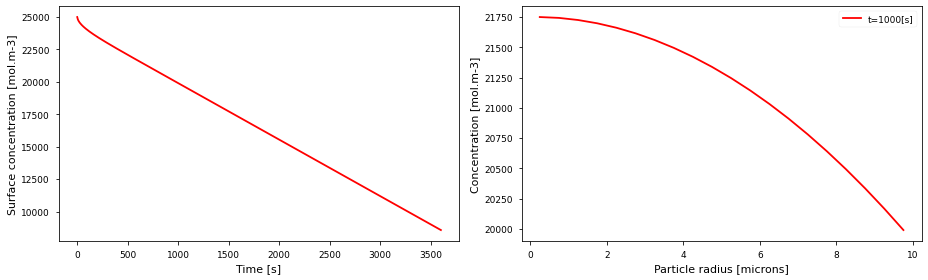

In [10]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 3600, 600)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Concentration [mol.m-3]"]
c_surf = solution["Surface concentration [mol.m-3]"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c_surf(solution.t))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Surface concentration [mol.m-3]")

r = mesh["negative particle"].nodes # radial position
time = 1000  # time in seconds
ax2.plot(r * 1e6, c(t=time, r=r), label="t={}[s]".format(time))
ax2.set_xlabel("Particle radius [microns]")
ax2.set_ylabel("Concentration [mol.m-3]")
ax2.legend()

plt.tight_layout()
plt.show()

# Using pre-defined models in `PyBaMM`

In the next few steps, we will be using the `DFN` and the `SPM` model to make the concepts explained above more clear. We will also see how you can pass a function as a `parameter's` value and how to plot such `parameter functions`.

We start by initializing our model and selecting `Chen2020` chemistry.

In [11]:
dfn_model = pybamm.lithium_ion.DFN()
spm_model = pybamm.lithium_ion.SPM()

chemistry = pybamm.parameter_sets.Chen2020
param = pybamm.ParameterValues(chemistry=chemistry)

## Finding the parameters in a model

We can print the `parameters` of a model by using the `parameters` function of the `BaseModel` class.

In [12]:
dfn_model.parameters

[Parameter(0x61aad17c8254da5a, Maximum concentration in negative electrode [mol.m-3], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x3d90036630c478c5, Negative electrode thickness [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x7c5ae8899714cc7d, Separator thickness [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(0x88a2da4602f0034, Positive electrode thickness [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x2e3faead431468dd, Typical current [A], children=[], domain=[], auxiliary_domains={}),
 Parameter(0x1fedf726b2c89af3, Number of electrodes connected in parallel to make a cell, children=[], domain=[], auxiliary_domains={}),
 Parameter(0x3147944a2afad6df, Electrode width [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(0x473a9458ed2598a0, Electrode height [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x6378d715f7261f59, Reference temperature [K], children=[], domain=[], auxiliary_domains={}

In [13]:
spm_model.parameters

[Parameter(0x61aad17c8254da5a, Maximum concentration in negative electrode [mol.m-3], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x3d90036630c478c5, Negative electrode thickness [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x7c5ae8899714cc7d, Separator thickness [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(0x88a2da4602f0034, Positive electrode thickness [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x2e3faead431468dd, Typical current [A], children=[], domain=[], auxiliary_domains={}),
 Parameter(0x1fedf726b2c89af3, Number of electrodes connected in parallel to make a cell, children=[], domain=[], auxiliary_domains={}),
 Parameter(0x3147944a2afad6df, Electrode width [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(0x473a9458ed2598a0, Electrode height [m], children=[], domain=[], auxiliary_domains={}),
 Parameter(-0x6378d715f7261f59, Reference temperature [K], children=[], domain=[], auxiliary_domains={}

We can also update `param` by using the `update` function but let us print it out first.

In [14]:
param

 0.5,
 'Lithium interstitial reference concentration [mol.m-3]': 15.0,
 'Lower voltage cut-off [V]': 2.5,
 'Maximum concentration in negative electrode [mol.m-3]': 33133.0,
 'Maximum concentration in positive electrode [mol.m-3]': 63104.0,
 'Negative current collector conductivity [S.m-1]': 58411000.0,
 'Negative current collector density [kg.m-3]': 8960.0,
 'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
 'Negative current collector thermal conductivity [W.m-1.K-1]': 401.0,
 'Negative current collector thickness [m]': 1.2e-05,
 'Negative electrode Bruggeman coefficient (electrode)': 1.5,
 'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,
 'Negative electrode OCP [V]': ('graphite_LGM50_ocp_Chen2020',
                                array([[0.        , 1.81772748],
       [0.03129623, 1.0828807 ],
       [0.03499902, 0.99593794],
       [0.0387018 , 0.90023398],
       [0.04240458, 0.79649431],
       [0.04610736, 0.73354429],
       [0.04981015, 0.

We will now search and update the `"Current function [A]"` first with a constant value and then with a function.

### Using a constant value:

In [15]:
param.search("Current function [A]")

param.update(
    {
        "Current function [A]": 4.0
    }
)

param["Current function [A]"]

Current function [A]	5.0


4.0

### Using a function:

In [16]:
def curren_func(time):
    return pybamm.sin(2 * np.pi * time / 60)

param.update(
    {
        "Current function [A]": curren_func
    }
)

param["Current function [A]"]

<function __main__.curren_func(time)>

## Plotting parameter functions

As seen above, functions can be passed as parameter values. These parameter values can then be plotted by using `pybamm.plot`

### Plotting "Current function \[A]"

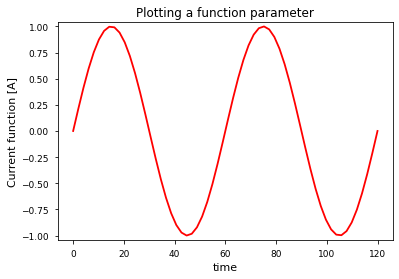

In [17]:
currentfunc = param["Current function [A]"]
time = pybamm.linspace(0, 120, 60)
evaluated = currentfunc(time)
processed = param.process_symbol(evaluated)
pybamm.plot(time, processed, xlabel="time", ylabel="Current function [A]", title="Plotting a function parameter")


Taking another such example:

### Plotting "Negative electrode exchange-current density \[A.m-2]"

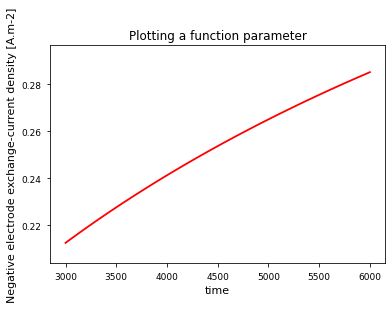

In [18]:
negative_electrode_exchange_current_density = param["Negative electrode exchange-current density [A.m-2]"]
x = pybamm.linspace(3000,6000,100)
evaluated = negative_electrode_exchange_current_density(1000,x,300)
processed = param.process_symbol(evaluated)
pybamm.plot(x, processed, xlabel="time", ylabel="Negative electrode exchange-current density [A.m-2]", title="Plotting a function parameter")

## Simulating and solving the model

Finally we can simulate the model and solve it using `pybamm.Simulation` and `solve` respectively.

### Using the DFN model:

In [19]:
sim = pybamm.Simulation(dfn_model, parameter_values=param)
t_eval = np.arange(0, 121, 1)
sim.solve(t_eval=t_eval)
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=120.0, step=1.2), Output()), _dom_classes=('…

### Using the SPM model

In [20]:
sim = pybamm.Simulation(spm_model, parameter_values=param)
t_eval = np.arange(0, 121, 1)
sim.solve(t_eval=t_eval)
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=120.0, step=1.2), Output()), _dom_classes=('…

## References
The relevant papers for this notebook are:

In [21]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with